# Python imports

In [145]:
import csv, time
import numpy as np
import multihash as mh
import hashlib as hl
import matplotlib.pyplot as plt
from binary_trie import Trie, bytes_to_bitstring, int_to_bitstring

# Plot design

In [146]:
plt.rc('font', size=28)

# Helper functions and classes

In [147]:
def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

def xor_bitstring(bs0: str, bs1: str) -> str:
    s = ""
    if len(bs0) == len(bs1):
        for i in range(len(bs0)):
            if bs0[i]==bs1[i]:
                s+='0'
            else:
                s+='1'
    return s

# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


In [148]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors_ids):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors_ids = neighbors_ids
        
        self.key = multihash_to_kad_id(peer_id)
        
        self.alive = len(neighbors_ids)>0
        
        self.buckets = [[] for _ in range(257)]
        self.neighbors = {}
        
    def distance(self, p):
        return xor_distance(self.key, p.key)
        
    def addNeighbor(self, peer):
        if bytes_to_bitstring(peer.key) not in self.neighbors:
            self.neighbors[bytes_to_bitstring(peer.key)]=(peer)
            self.buckets[bucket_number_for_distance(self.distance(peer))].append(peer)
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors_ids)


# Gathering data for plots

## Global variables used to collect data from the crawls before plotting it

In [171]:
routing_table_distribution_in_kbuckets_data = [[] for _ in range(257)]
routing_table_distribution_in_kbuckets_alive_data = [[] for _ in range(257)]

In [172]:
peerids_distribution_data = []
peerids_distribution_chunk88_data = [] # 1011000

In [173]:
closest20_cdf_data = []

In [174]:
missing_peers_per_bucket_data = []
missing_peers_per_non_full_bucket_data = []

In [175]:
closest_peers_data = [[] for _ in range(20)]

## Routing table distribution in the k-buckets

In [176]:
def routing_table_distribution_in_kbuckets(peers, data):
    # creating empty buckets
    buckets=[[] for _ in range(257)]

    # aggregating the number of entries per bucket for all peers
    for pid in peers:
        p=peers[pid]
        if p.alive:
            for i in range(len(p.buckets)):
                data[i].append(len(p.buckets[i]))

In [177]:
levels=7

def peerids_distribution(peers):
    # getting the list of bitstrings for the given peerids
    peerids = [bytes_to_bitstring(peers[p].key) for p in peers]
    
    trie = Trie()
    for p in peerids:
        trie.add(p)
        
    density=[0] * 2**levels

    for i in range(2**levels):
        path="{0:b}".format(i)           # getting binary number
        path='0'*(levels-len(path))+path # zero padding for constant size bitstring

        density[i]=trie.find_trie(path).size
        
    peerids_distribution_data.append(density)
    
    levels88 = 4
    density88 = [0] * 2**levels88
    for i in range(2**levels88):
        path="{0:b}".format(i)           # getting binary number
        path='0'*(levels88-len(path))+path # zero padding for constant size bitstring
        path=int_to_bitstring(88,7)+path

        for p in peerids:
            if p[:len(path)] == path:
                density88[i]+=1
                
        
    peerids_distribution_chunk88_data.append(density88)

    """
    THIS NEEDS TO HAVE A Trie.find_trie_or_child(key) FUNCTION OR Trie.subtrie_size(key) / Trie.keys_with_prefix()
    
    levels88 = 2
    density88 = [0] * 2**levels88
    for i in range(2**levels88):
        path="{0:b}".format(i)           # getting binary number
        path='0'*(levels-len(path))+path # zero padding for constant size bitstring
        path=int_to_bitstring(88,7)+path
        
        node = trie.find_trie(path)
        density88[i]= 0 if node is None else node.size
        
    peerids_distribution_chunk88_data.append(density88)
    """


In [178]:
def closest20_cdf(peers, all_peers, trie):
    neighbors20 = []
    for p in peers:
        peers20 = trie.n_closest(bytes_to_bitstring(peers[p].key), 21)[1:]
        # peerset20 = t.n_closest(bytes_to_bitstring(alive_peers[p].key), 21)[1:] # that is wrong
        # we should test the actual neighbors e.g peers[p].neighbors
        neighbors = [all_peers[p].neighbors[n].key for n in all_peers[p].neighbors]

        count = 0
        for p in peers20:
            if p.key in neighbors:
                count+=1
        neighbors20.append(count)

    closest20_cdf_data.append(neighbors20)

In [179]:
def missing_peer_in_buckets(peers, trie): # TODO: pass parameter and rename variables
    non_full_buckets = [0] * 255
    missing_peers_in_bucket = [0] * len(non_full_buckets)

    for p in peers:
        for bid in range(len(non_full_buckets)):
            blen = len(peers[p].buckets[bid])
            if blen < 20:
                non_full_buckets[bid] += 1

                # bucket number = CPL
                key = bytes_to_bitstring(peers[p].key)
                path = key[:bid]+str(1-int(key[bid+1]))

                subtrie = trie.find_trie(path)
                if subtrie is None:
                    # we want to find out if it is included in a path
                    # or if it is not present at all in the trie
                    subtrie = trie
                    while len(subtrie.key) < len(path):
                        subtrie = subtrie.branch[int(path[len(subtrie.key)])]
                        m = min(len(path),len(subtrie.key)+1)
                        if subtrie.key[:m] != path[:m]:
                            # subtrie doesn't exist
                            subtrie = None
                            break

                if subtrie is not None and subtrie.size > blen:
                    missing_peers_in_bucket[bid] += min(subtrie.size,20) - blen
                    
    missing_peers_per_bucket_data.append([missing_peers_in_bucket[i]/len(peers) for i in range(len(non_full_buckets))])
    missing_peers_per_non_full_bucket_data.append([missing_peers_in_bucket[i]/non_full_buckets[i] if non_full_buckets[i] > 0 else 0 for i in range(len(non_full_buckets))])
                


In [180]:
def closest20_bucket_distribution(peers, all_peers, trie):
    for p in peers:
        # get 20 closest neighbors from the trie
        closest20 = trie.n_closest(bytes_to_bitstring(all_peers[p].key), 21)[1:]

        for i in range(len(closest20)):
            d=xor_distance(peers[p].key, closest20[i].key)
            bucket=bucket_number_for_distance(d)

            closest_peers_data[i].append(bucket)


# Loading data exctracted from the Nebula Crawler DB

- `nebula_peerids` is a mapping from the Nebula ID to the peer ID for all hosts observed by Nebula over the time period `2022-02-16 10:30:01.706317+01` to `2022-05-03T13:01:17.238Z`

- `all_crawls` is a list of `[crawl_id, nebula_id, peer_id, neighbor0, neighbor1, ... neighborN]` for all diable peers for the selected crawls.

In [181]:
with open("data/all-peerids.csv", 'r') as file:
    nebula_peerids = {line[0]:line[1] for line in csv.reader(file)}

In [182]:
filename = "data/nebula-peers-2crawls.csv"

In [183]:
with open(filename, 'r') as file:
    all_crawls = [line for line in csv.reader(file)]

In [184]:
crawl_id = all_crawls[0][0]
peers = {}
startTime = time.time()
crawl_count = 0
alive_peers_per_crawl = []
total_peers_per_crawl = []

for i in range(len(all_crawls)):
    entry = all_crawls[i]
        
    # add entry to peers
    peers[entry[1]] = NebulaPeer(entry[1], entry[2], entry[3:])

    if i == len(all_crawls)-1 or all_crawls[i+1][0] != crawl_id:
        # do all computations for the crawl
        print("Crawl", crawl_id, ":", len(peers),"alive peers crawled, time elapsed:", time.time() - startTime)
                
        # stale peers count
        stale_count = 0
        all_peers = peers.copy()
        # define neighbor relationships
        for p in peers:
            for n in peers[p].neighbors_ids:
                if n in peers:
                    peers[p].addNeighbor(peers[p])
                else:
                    stale_count += 1
                    all_peers[n] = NebulaPeer(n, nebula_peerids[n], [])
                all_peers[p].addNeighbor(all_peers[n])
                
        t = Trie()
        for p in peers:
            t.add(bytes_to_bitstring(peers[p].key), metadata=peers[p])
        print("Done with data structures", time.time() - startTime)
                
        routing_table_distribution_in_kbuckets(all_peers, routing_table_distribution_in_kbuckets_data)
        routing_table_distribution_in_kbuckets(all_peers, routing_table_distribution_in_kbuckets_alive_data)
        closest20_cdf(peers, all_peers, t)
        missing_peer_in_buckets(peers, t) # takes a lot of time (~45 sec)
        peerids_distribution(all_peers)
        closest20_bucket_distribution(peers, all_peers, t)
            
        crawl_count += 1
        alive_peers_per_crawl.append(len(peers))
        total_peers_per_crawl.append(len(all_peers))

        print("Crawl", crawl_id, "finished, stale peers:", stale_count,", total time elapsed:", time.time() - startTime)
        
        # reset variables for next crawl
        if i < len(all_crawls) - 1:
            peers = {}
            crawl_id = all_crawls[i+1][0]
            startTime = time.time()
        

Crawl 3518 : 16837 alive peers crawled, time elapsed: 0.47624754905700684
Done with data structures 123.38643455505371
Crawl 3518 finished, stale peers: 166782 , total time elapsed: 174.5576581954956
Crawl 3519 : 16908 alive peers crawled, time elapsed: 0.4802064895629883
Done with data structures 129.88365864753723
Crawl 3519 finished, stale peers: 164699 , total time elapsed: 181.11778020858765


# Information about data

In [185]:
avg_peers_per_crawl = sum(alive_peers_per_crawl)/len(alive_peers_per_crawl)
total_avg_peers_per_crawl = sum(total_peers_per_crawl)/len(total_peers_per_crawl)

In [186]:
print("Data coming from", crawl_count, "different crawls")
print(" "*4, avg_peers_per_crawl, "alive peers per crawls on average")
print(" "*4, total_avg_peers_per_crawl, "total peers per crawl on average")

Data coming from 2 different crawls
     16872.5 alive peers per crawls on average
     22015.0 total peers per crawl on average


# Plots

## Routing table distribution in the k-buckets

Whiskers at $5^{th}$ and $95^{th}$ percentile. Orange line is mean. Box is `Q1` to `Q3`

In [187]:
avg_in_bucket= np.average(routing_table_distribution_in_kbuckets_data, axis=1)

## All peers present in the routing tables

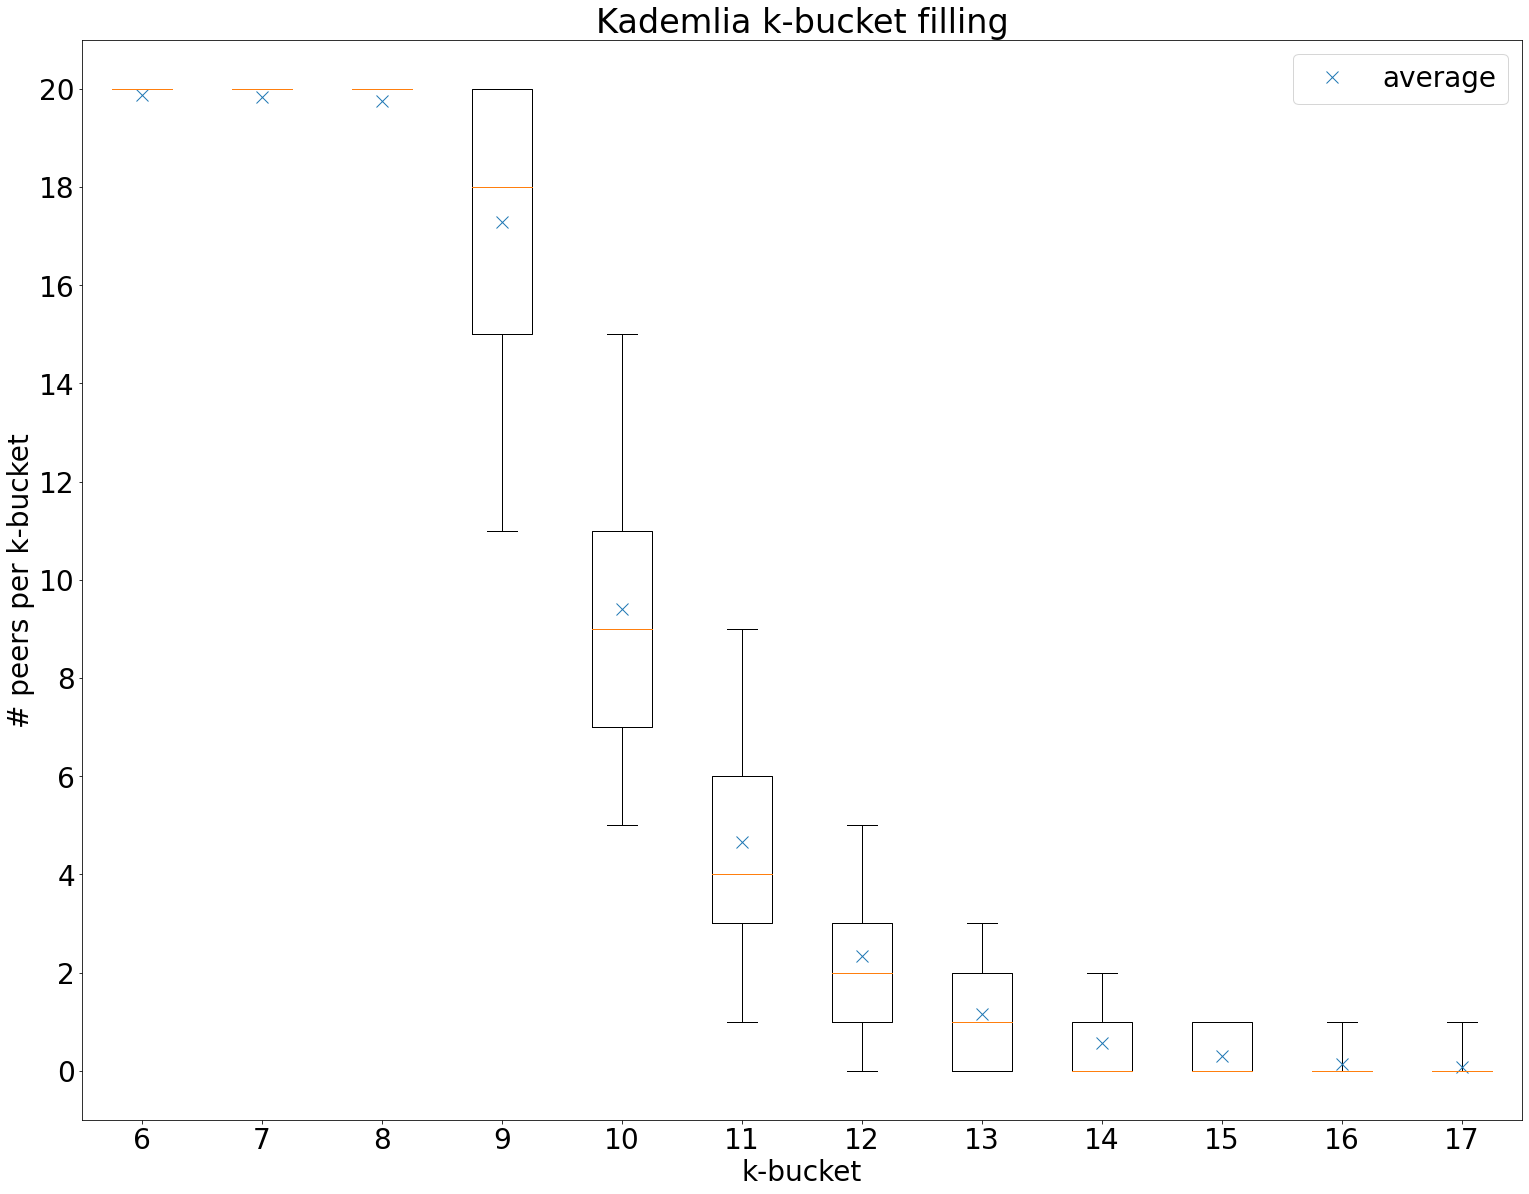

In [191]:
fig = plt.figure(figsize=(20,15), facecolor='white', edgecolor ='black')
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
plt.yticks(range(0, 21, 2))


bp = ax.boxplot(routing_table_distribution_in_kbuckets_data[6:18], positions=range(6,18),\
                showfliers=False, whis=(5, 95))

plt.plot(range(6,18), avg_in_bucket[6:18], marker='x', markersize=12, ls='', label='average')

plt.xlabel("k-bucket")
plt.ylabel("# peers per k-bucket")
plt.grid(False)

plt.title("Kademlia k-bucket filling")
plt.legend()

plt.savefig("plots/kbucket-filling-distribution-test.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

## Alive peers only

In [188]:
avg_alive_in_bucket = np.average(routing_table_distribution_in_kbuckets_data, axis=1)

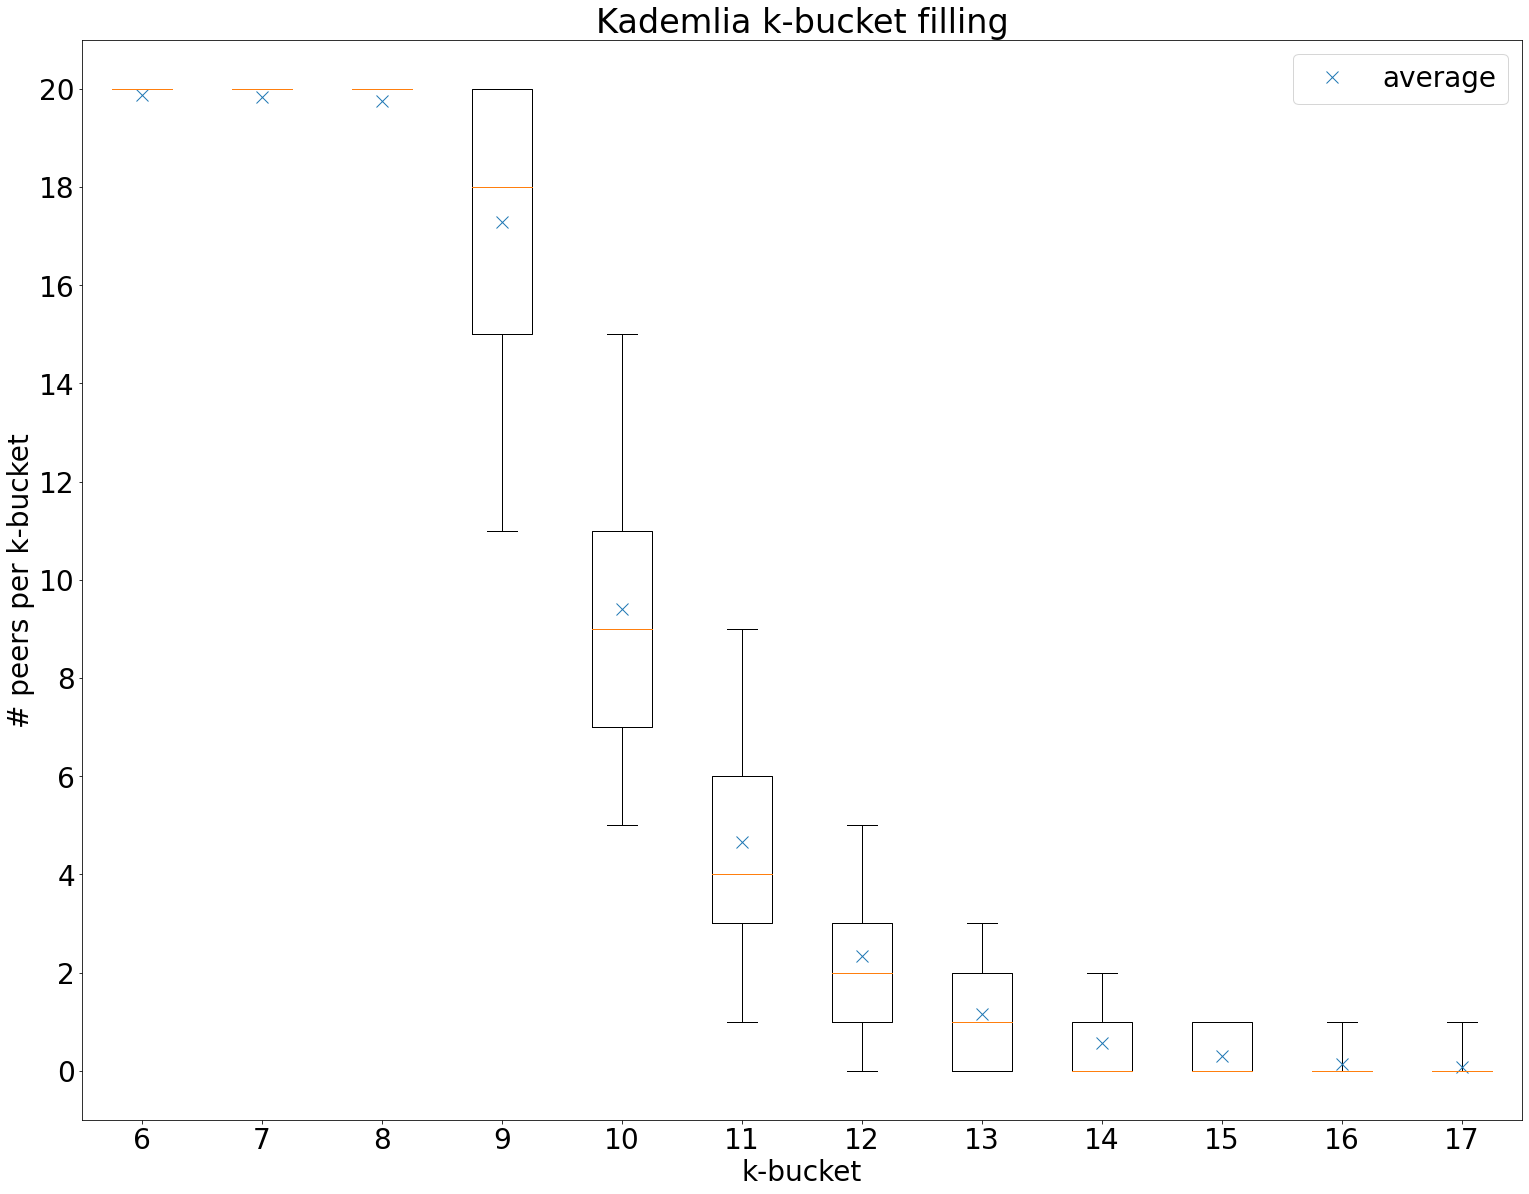

In [190]:
fig = plt.figure(figsize=(20,15), facecolor='white', edgecolor ='black')
ax = fig.add_axes([0, 0, 1, 1])

#ax.set_xlim(220,257)
plt.yticks(range(0, 21, 2))


bp = ax.boxplot(routing_table_distribution_in_kbuckets_alive_data[6:18], positions=range(6,18),\
                showfliers=False, whis=(5, 95))

plt.plot(range(6,18), avg_alive_in_bucket[6:18], marker='x', markersize=12, ls='', label='average')

plt.xlabel("k-bucket")
plt.ylabel("# peers per k-bucket")
plt.grid(False)

plt.title("Kademlia k-bucket filling")
plt.legend()

plt.savefig("plots/kbucket-filling-distribution-alive-new.png",
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

In [194]:
closest20_average = []
for data in closest20_cdf_data:
    closest20_average += data

In [195]:
closest20_pdf = [closest20_average.count(x)/len(closest20_average) for x in range(21)]
closest20_cdf = [sum(closest20_pdf[:i+1]) for i in range(len(closest20_pdf))]

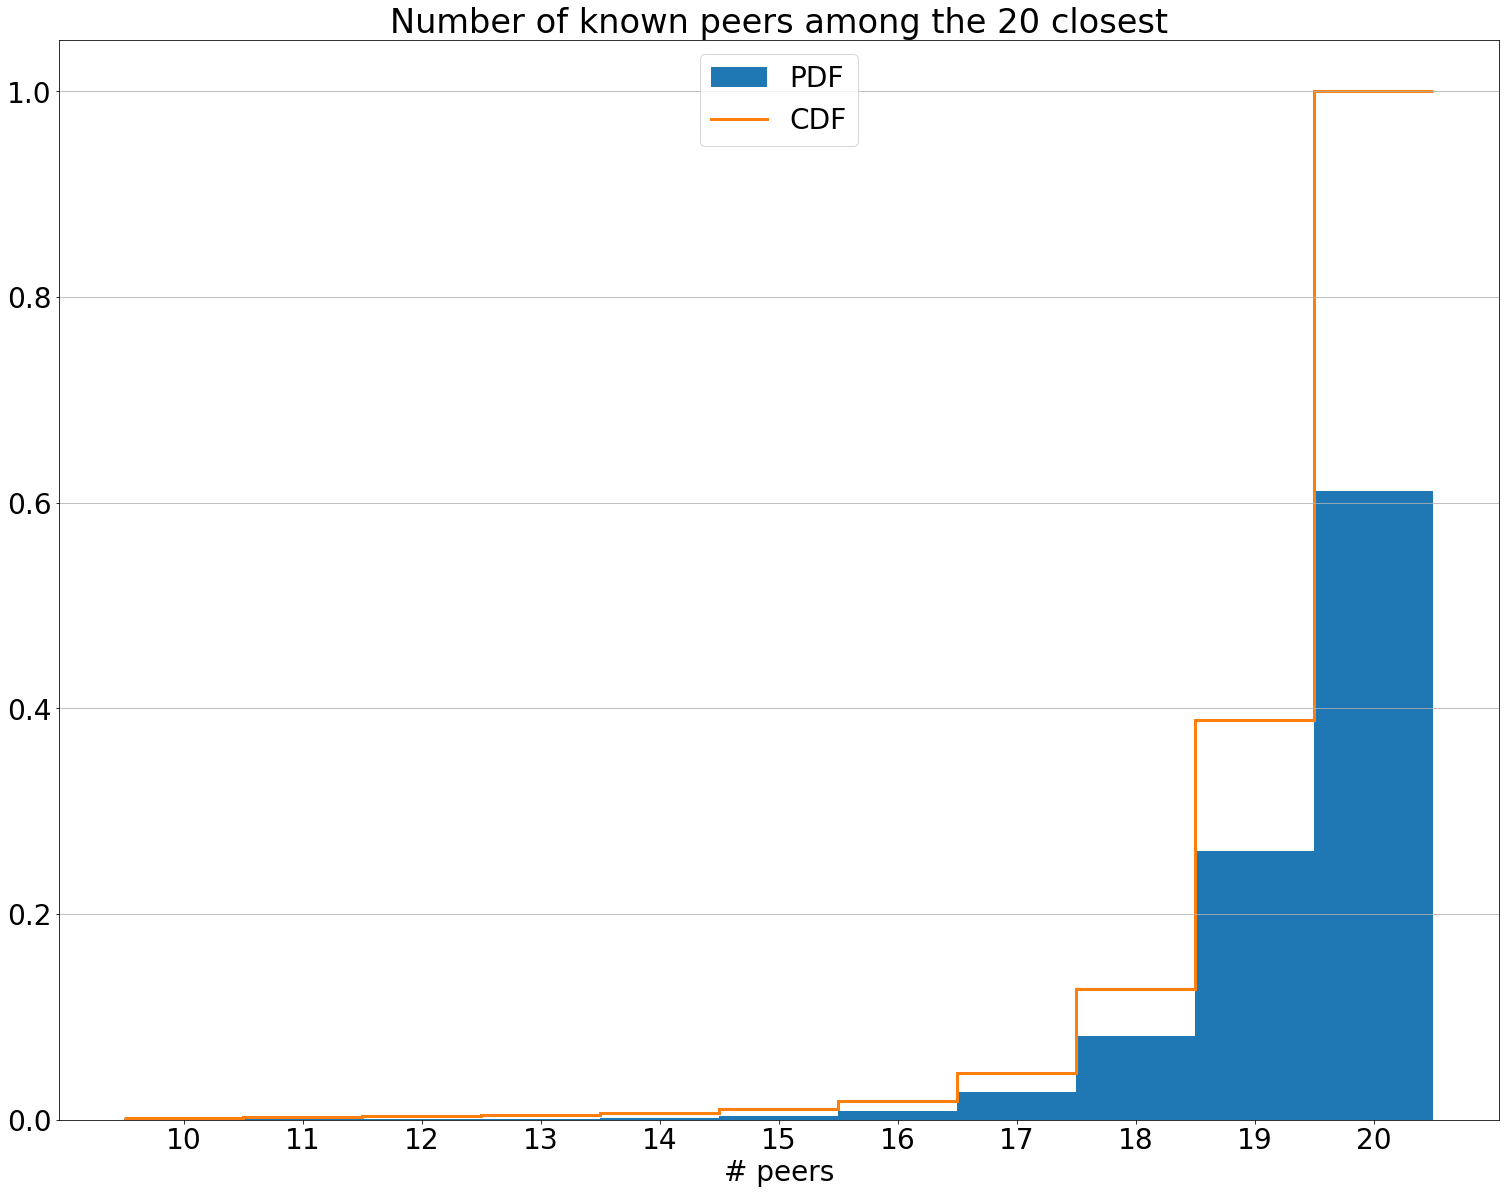

In [196]:
fig = plt.figure(figsize=(20,15), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

ax.stairs(values=closest20_pdf[10:], edges=[x - 0.5 for x in range(10, 22)], label='PDF', fill=True)
ax.stairs(values=closest20_cdf[10:], edges=[x - 0.5 for x in range(10, 22)], label='CDF', linewidth=3, baseline=None)

plt.grid(axis='y')
plt.xlabel("# peers")
plt.xticks(range(10, 21))
plt.legend(loc='upper center')
plt.title("Number of known peers among the 20 closest")
plt.savefig('plots/known-peers-among-20-closest-new.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [197]:
missing_peers_per_bucket_avg = np.average(missing_peers_per_bucket_data, axis=0)
missing_peers_per_non_full_bucket_avg = np.average(missing_peers_per_non_full_bucket_data, axis=0)

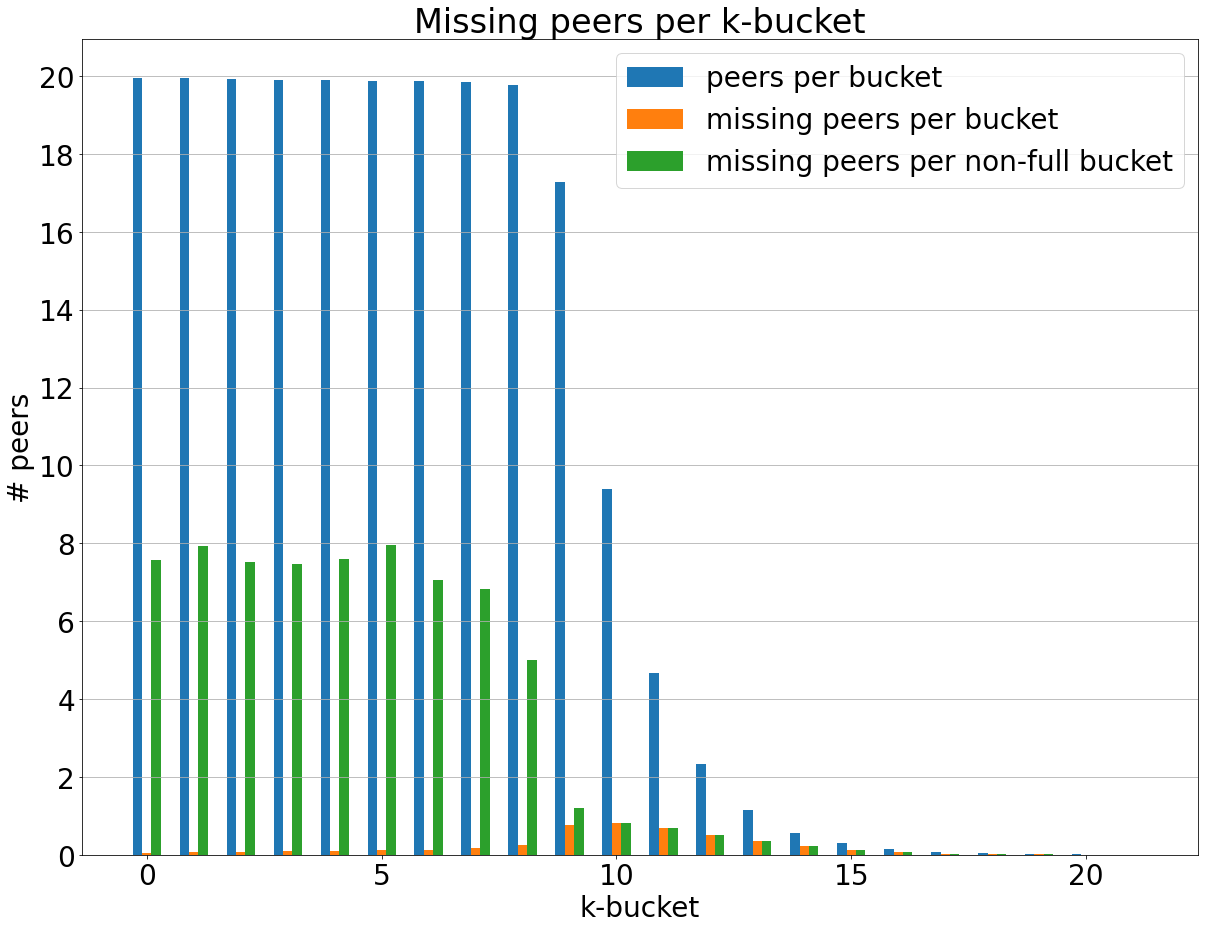

In [198]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.yticks(range(0, 22, 2))

plt.grid(axis='y')
plt.bar([x - 0.2 for x in range(22)], avg_in_bucket[:22], width=0.2, label='peers per bucket')
plt.bar([x for x in range(22)], missing_peers_per_bucket_avg[:22], width=0.2, label='missing peers per bucket')
plt.bar([x + 0.2 for x in range(22)], missing_peers_per_non_full_bucket_avg[:22], width=0.2, label='missing peers per non-full bucket')

#plt.bar(range(22), missing_peers_per_non_full_bucket[:22], width=0.25)

#plt.bar([x+232 for x in range(len(ratio_bucket[232:]))], ratio_bucket[232:], width=0.25)

plt.title('Missing peers per k-bucket')
plt.xlabel("k-bucket")
plt.ylabel("# peers")
plt.legend()

plt.savefig('plots/missing-peers-new.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

## Ratio of missing peers per bucket

In [215]:
missing_peers_per_bucket_ratio = [missing_peers_per_bucket_avg[i]/avg_in_bucket[i] for i in range(23)]

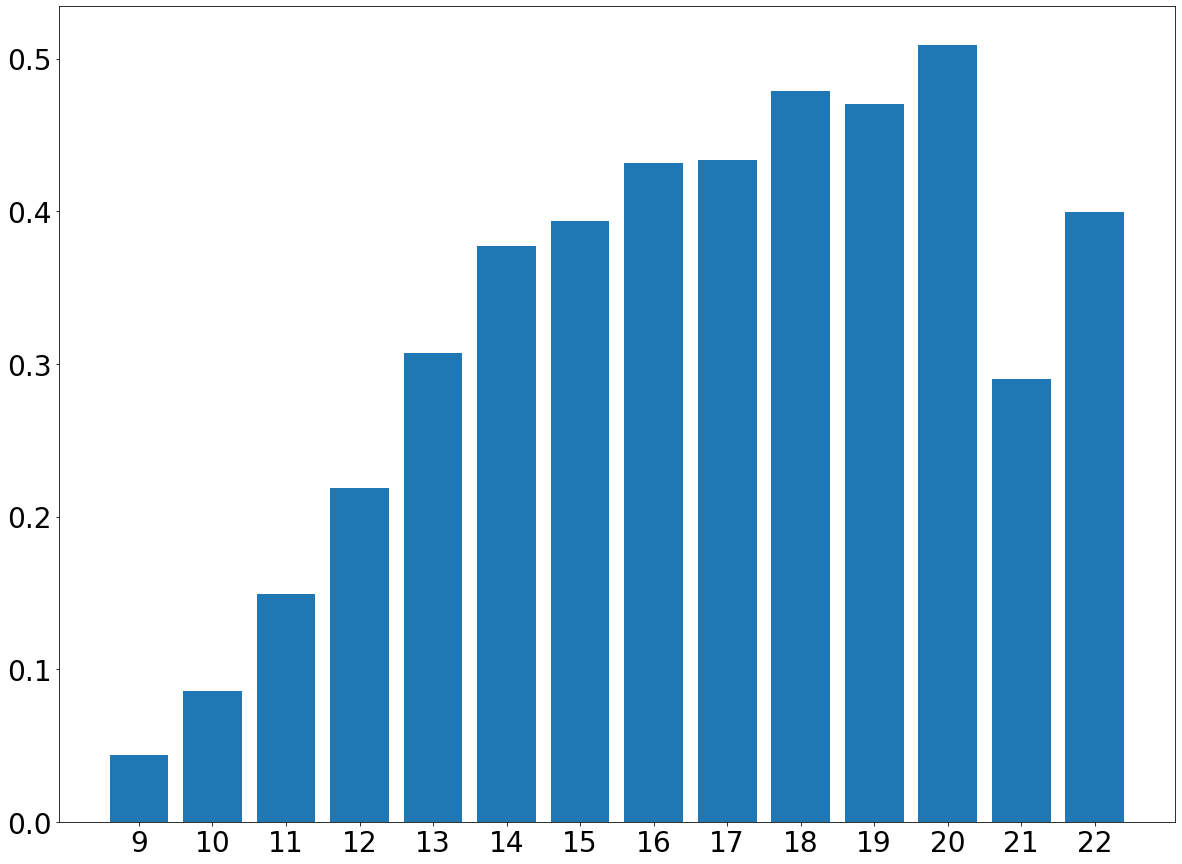

In [216]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.xticks(range(9, 23, 1))
plt.bar(range(9,23), missing_peers_per_bucket_ratio[9:23], label='average')
plt.show()

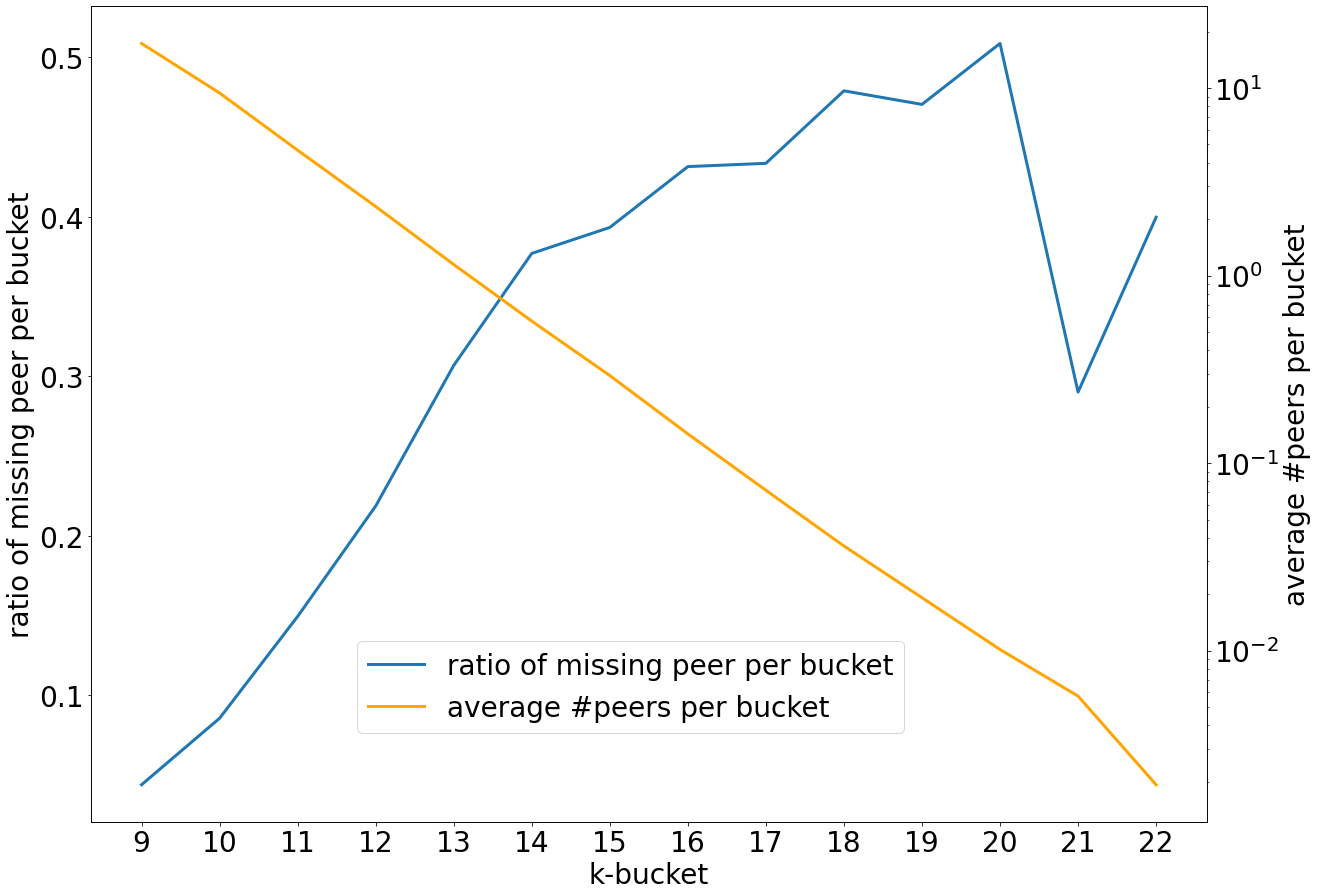

In [279]:
fig, ax1 = plt.subplots(figsize=(20,15), facecolor='white') 
      
plt.xticks(range(9,23))
ax1.set_xlabel('k-bucket')
ax1.set_ylabel('ratio of missing peer per bucket')
plot_1 = ax1.plot(range(9,23), missing_peers_per_bucket_ratio[9:23], label='ratio of missing peer per bucket', linewidth=3)
ax1.tick_params(axis ='y') 

# Adding Twin Axes

ax2 = ax1.twinx()
  
ax2.set_ylabel('average #peers per bucket')
ax2.set_yscale('log')
plot_2 = ax2.plot(range(9,23), avg_in_bucket[9:23], label='average #peers per bucket', color='orange', linewidth=3)
ax2.tick_params(axis ='y')

fig.legend(loc='center',bbox_to_anchor=(0.5, 0.25))
# Show plot

plt.show()

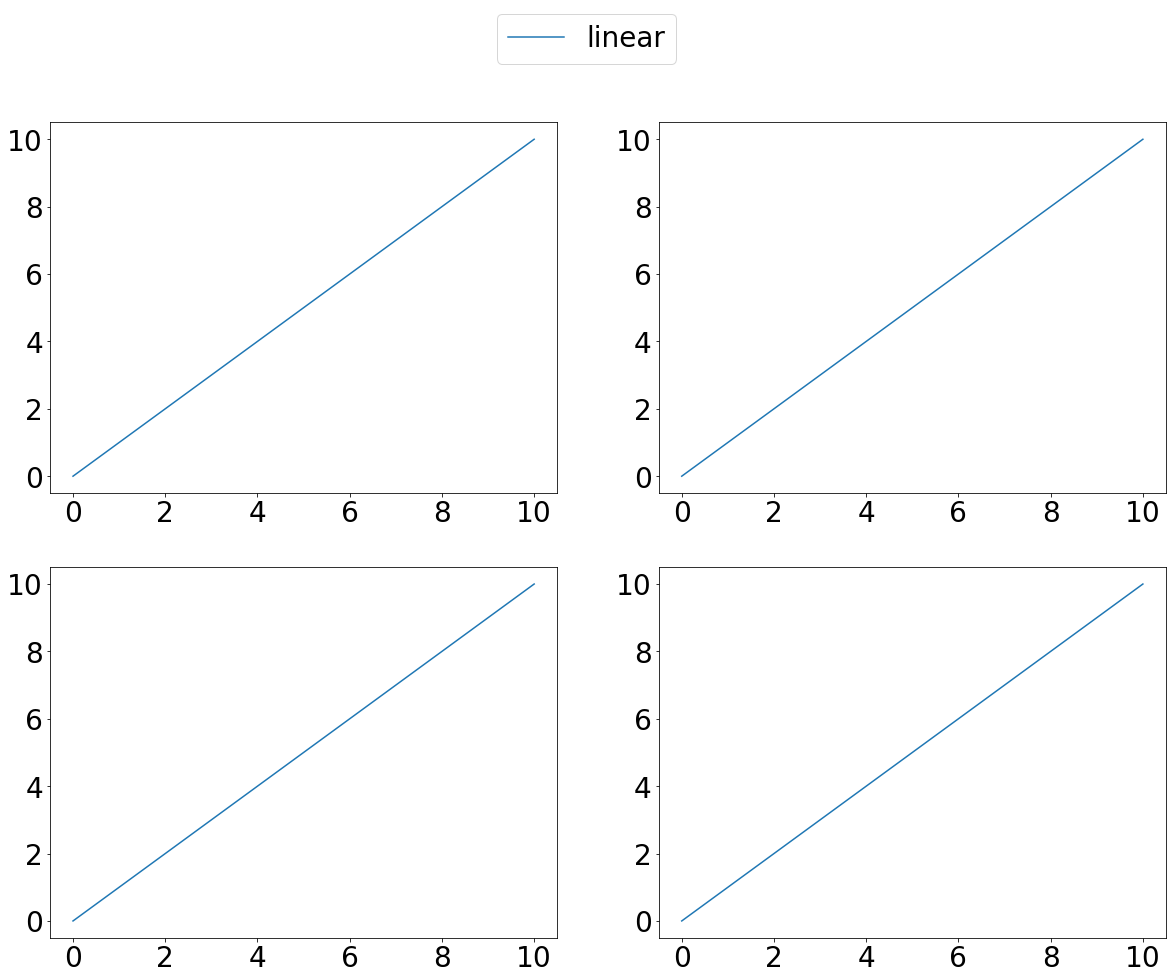

In [242]:

fig = plt.figure(figsize=(20,15), facecolor='white')
axes = fig.subplots(nrows=2, ncols=2)


for ax in fig.axes:
    ax.plot([0, 10], [0, 10], label='linear')

lines, labels = fig.axes[-1].get_legend_handles_labels()
    
fig.legend(lines, labels, loc = 'upper center')

plt.show()

In [236]:
closest_peers_avg = []
for line in closest_peers_data:
    closest_peers_avg.append(sum(line)/len(line))

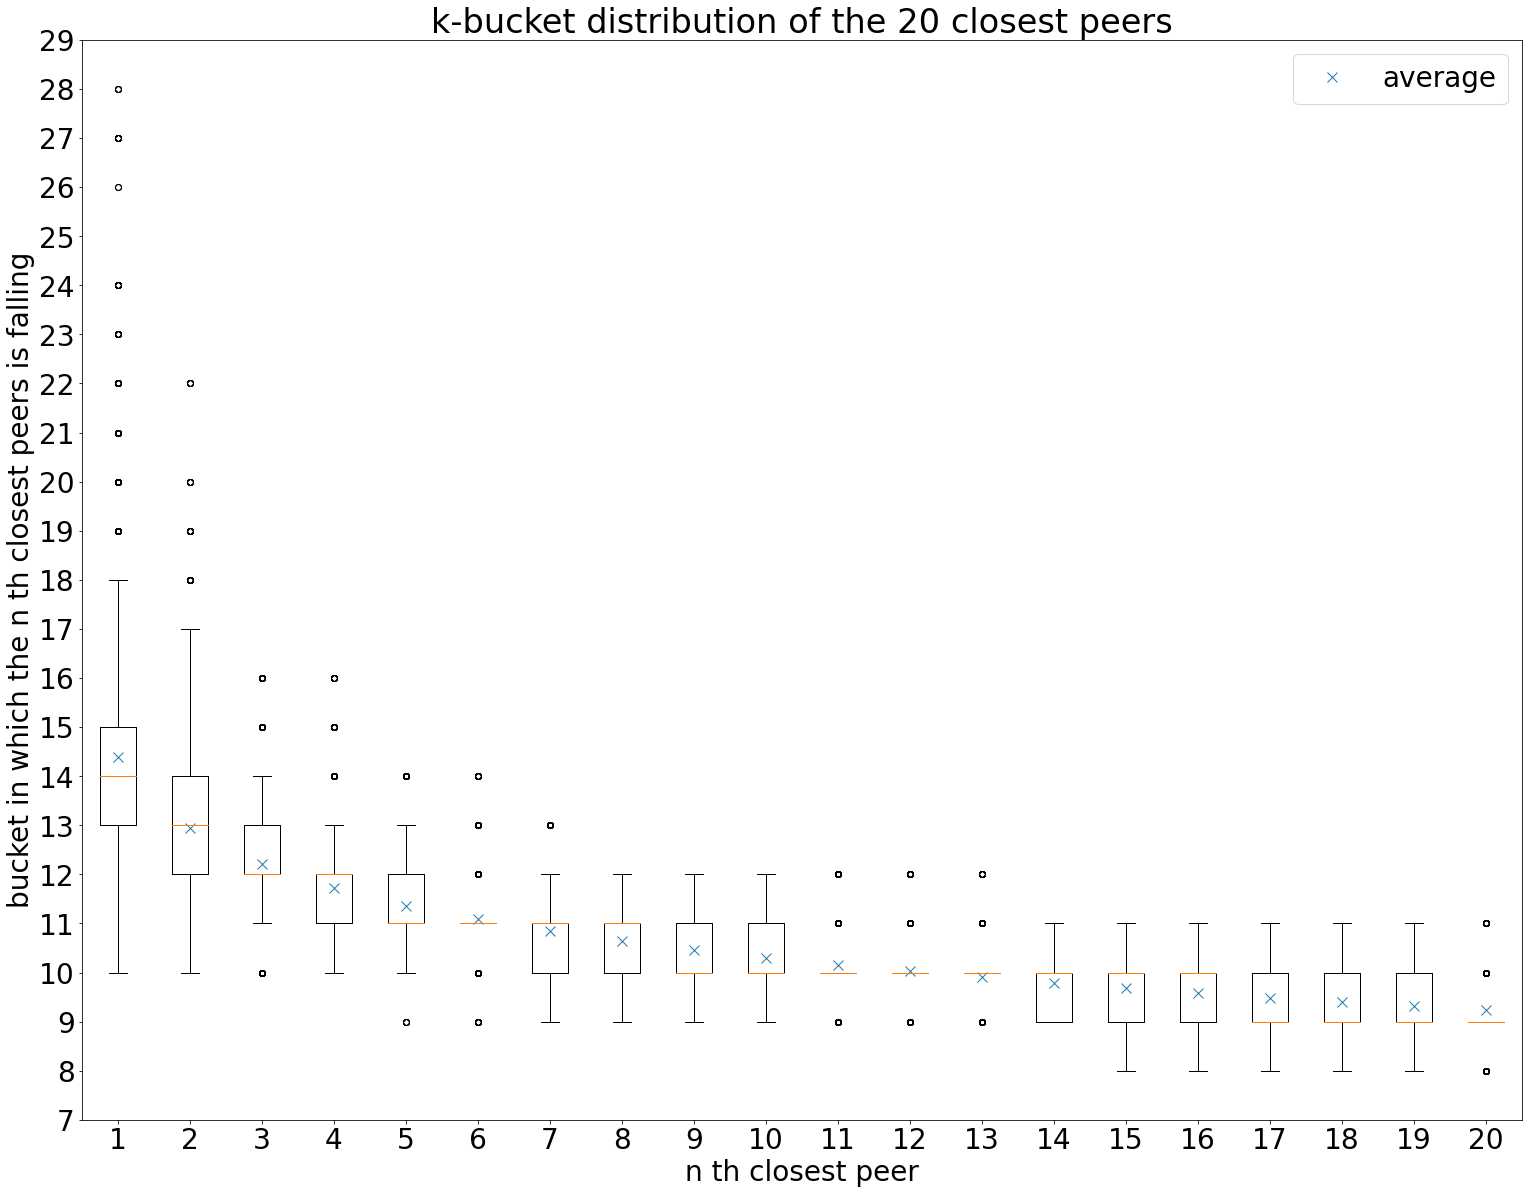

In [166]:
fig = plt.figure(figsize=(20,15), facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])

plt.yticks(range(5, 31, 1))

plt.grid(False)
plt.xlabel("n th closest peer")
plt.ylabel("bucket in which the n th closest peers is falling")

#plt.title("IPFS network: Kademlia k-bucket filling")

bp = ax.boxplot(closest_peers_data)
ax.plot(range(1,21),closest_peers_avg, marker='x', markersize=10, ls='', label='average')

plt.legend()
plt.title("k-bucket distribution of the 20 closest peers")
 
plt.savefig('plots/kbucket-distribution-20-closest-peers-new.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

# show plot
plt.show()

In [122]:
xClosest = []
for i in range(len(closest_peers_data)):
    total=sum([closest_peers_data[i].count(b) for b in range(9,24)])
    xClosest.append([closest_peers_data[i].count(b)/total for b in range(9,24)])

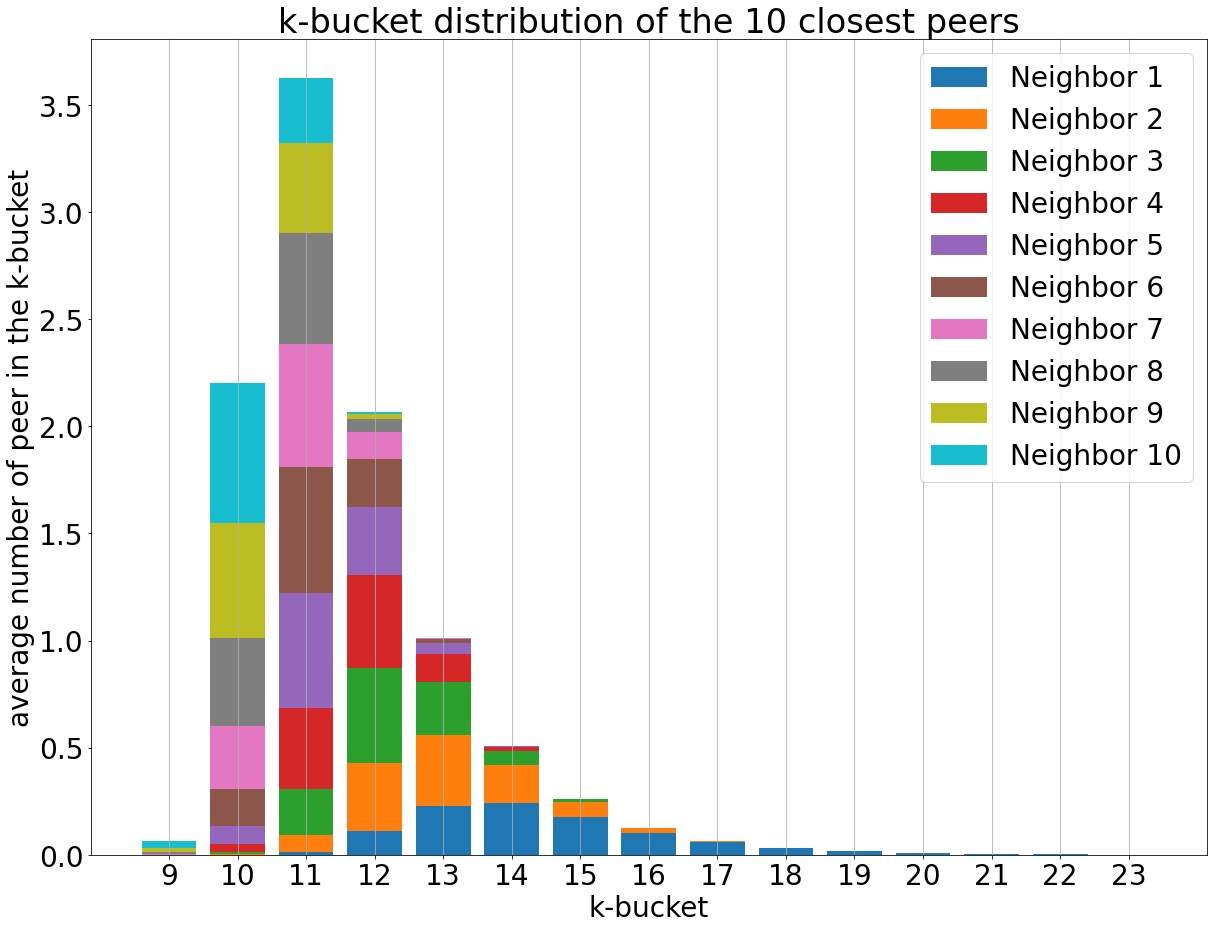

In [123]:
fig, ax = plt.subplots(figsize=(20,15), facecolor='white')

plt.xticks(range(9, 24, 1))

cumsum=[0 for _ in range(9,24)]

for i in range(10):
    label="Neighbor "+str(i+1)
    ax.bar(range(9,24), xClosest[i], bottom=cumsum, label=label)        
    cumsum = [cumsum[j]+xClosest[i][j] for j in range(len(cumsum))]
    
ax.legend()
plt.grid(axis='x')

plt.title("k-bucket distribution of the 10 closest peers")
plt.xlabel("k-bucket")
plt.ylabel("average number of peer in the k-bucket")
plt.savefig('plots/distribution-10-closest-peers.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

# PeerID distribution

Odd distribution peak with prefix _10110001001_

In [125]:
density = np.average(peerids_distribution_data, axis=0)

In [126]:
print("Average:            ", round(np.average(density),2))
print("Standard deviation:  ", round(np.std(density, ddof=1),2))
print("Max:                ", max(density))
print("Min:                ", min(density))

Average:             171.99
Standard deviation:   18.33
Max:                 287.0
Min:                 129.0


In [127]:
for i in range(len(density)):
    if density[i] == 287:
        print(i)

88


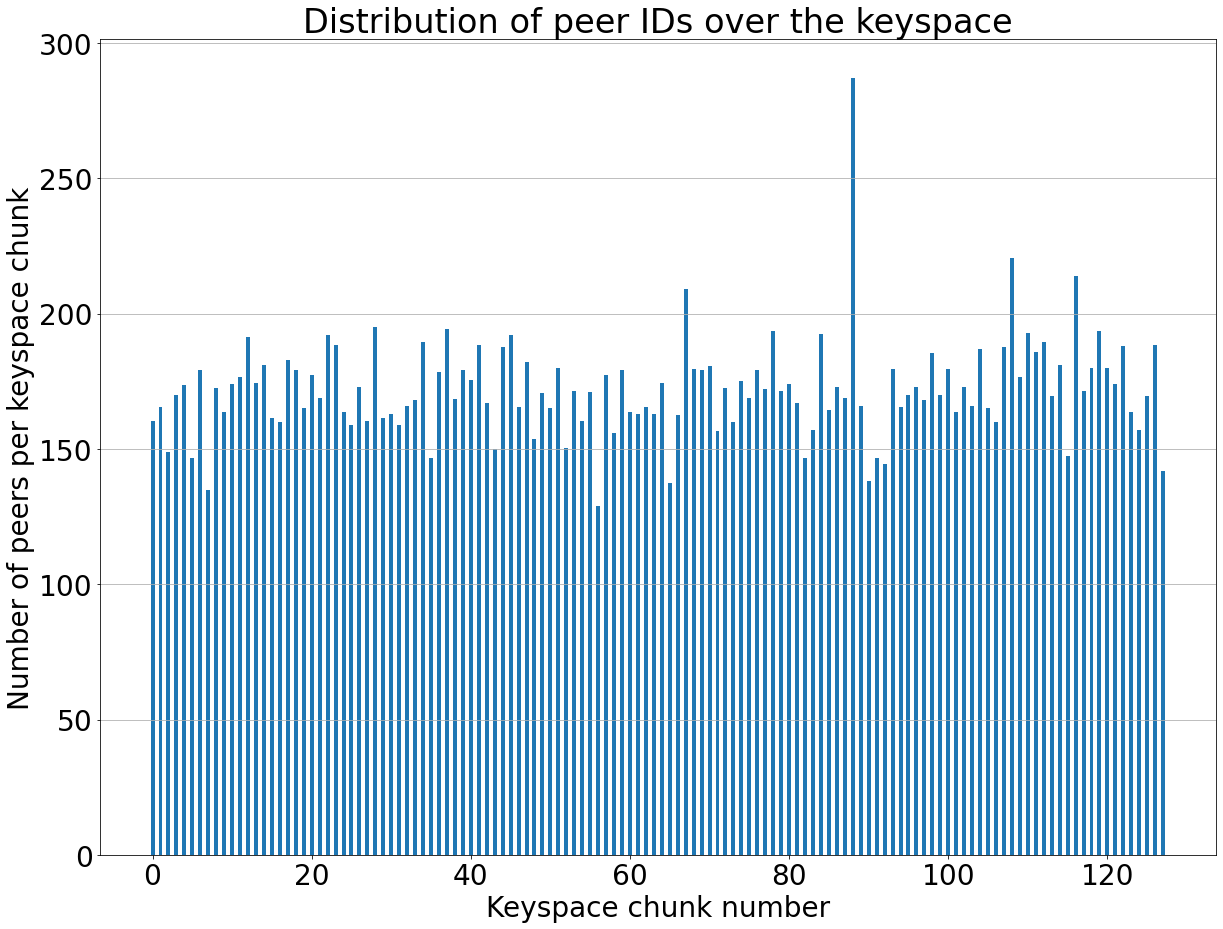

In [128]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/online-peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [129]:
density88 = np.average(peerids_distribution_chunk88_data, axis=0)

In [130]:
print("       prefix : occurences\n")
for i in range(len(density88)):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(4-len(path))+path
    path=int_to_bitstring(88,7)+path
    
    print(path+":", int(density88[i]))

       prefix : occurences

10110000000: 8
10110000001: 15
10110000010: 11
10110000011: 9
10110000100: 16
10110000101: 13
10110000110: 17
10110000111: 13
10110001000: 21
10110001001: 92
10110001010: 10
10110001011: 13
10110001100: 12
10110001101: 11
10110001110: 13
10110001111: 10


In [131]:
print("Average:            ", round(np.average(density88),2))
print("Standard deviation:  ", round(np.std(density88, ddof=1),2))
print("Max:                ", max(density88))
print("Min:                ", min(density88))

Average:             17.94
Standard deviation:   20.02
Max:                 92.0
Min:                 8.0


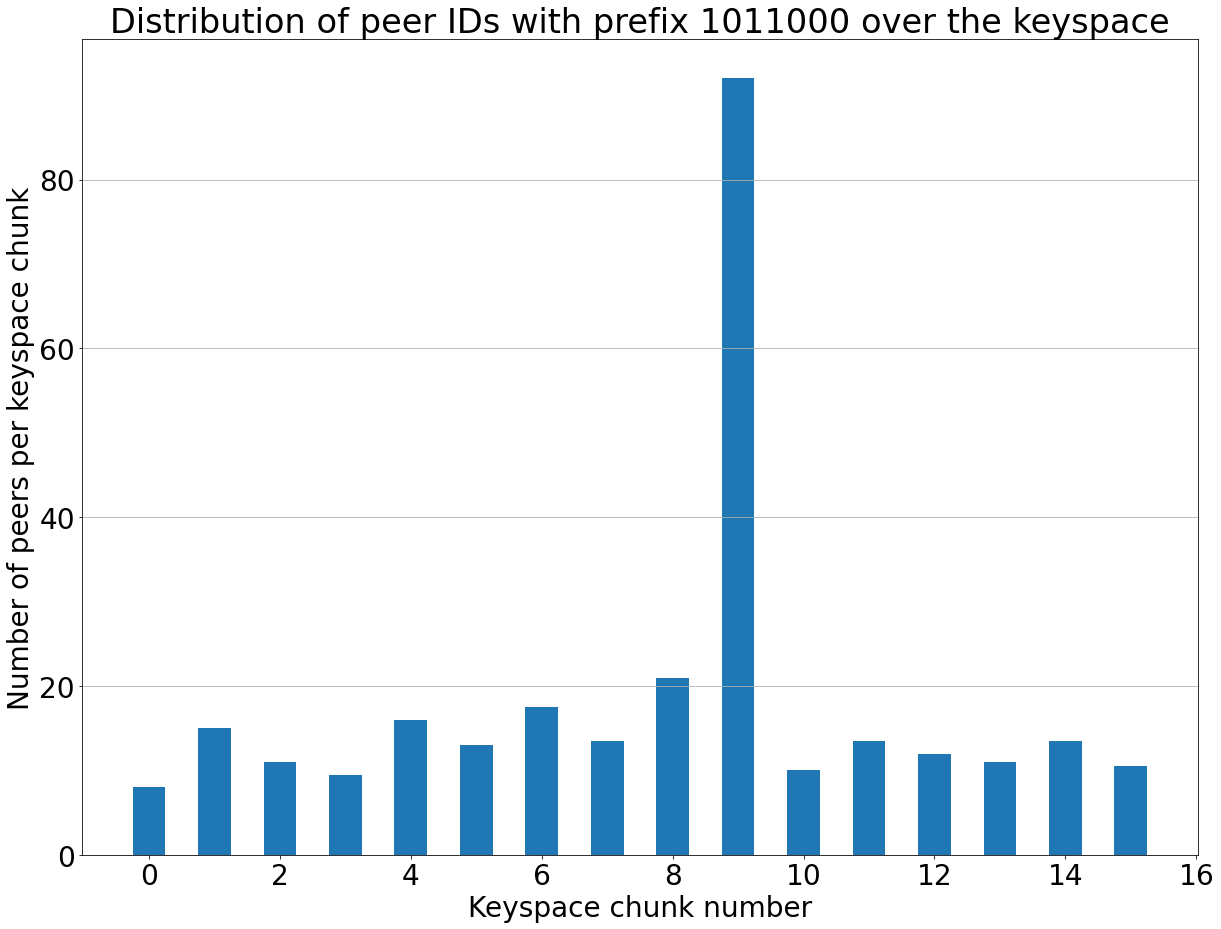

In [132]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs with prefix 1011000 over the keyspace")

plt.bar([x for x in range(len(density88))], density88, width=0.5)

plt.savefig('plots/online-peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

## PeerID distribution over keyspace (all times)

In [133]:
startTime = time.time()
peerids = [bytes_to_bitstring(multihash_to_kad_id(nebula_peerids[m])) for m in nebula_peerids]
print(time.time() - startTime)

6.4289631843566895


In [134]:
startTime = time.time()
t = Trie()
for p in peerids:
    t.add(p)
print(time.time() - startTime)

6.984198570251465


In [135]:
levels=7
density=[0]*2**levels

In [136]:
startTime = time.time()
for i in range(2**levels):
    path="{0:b}".format(i)
    path='0'*(levels-len(path))+path
    
    density[i]=t.find_trie(path).size
print(time.time() - startTime)

0.0006508827209472656


In [137]:
print("Average:            ", round(np.average(density),2))
print("Standard deviation:   ", round(np.std(density, ddof=1),2))
print("Max:                ", max(density))
print("Min:                ", min(density))

Average:             3419.62
Standard deviation:    69.83
Max:                 3632
Min:                 3199


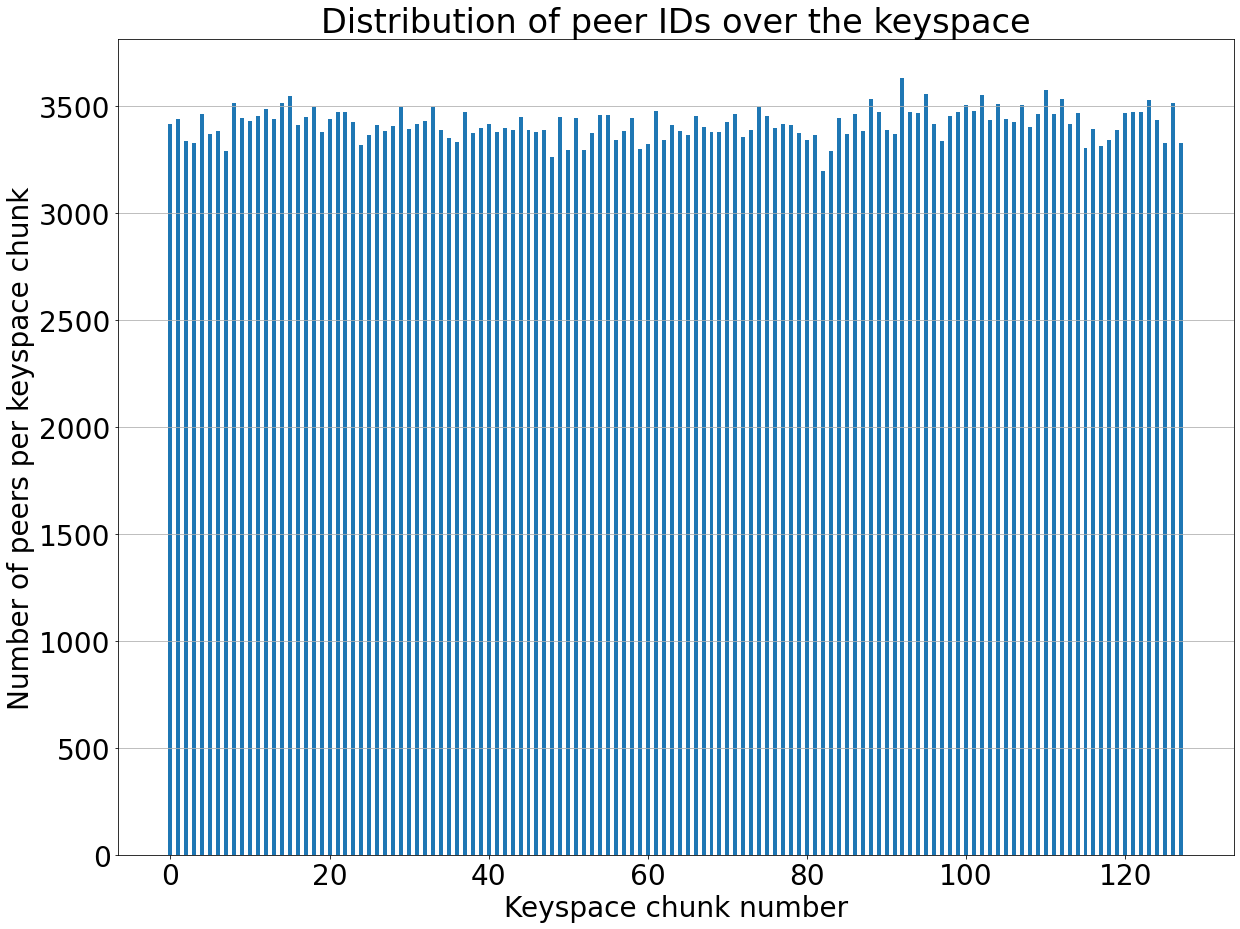

In [138]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

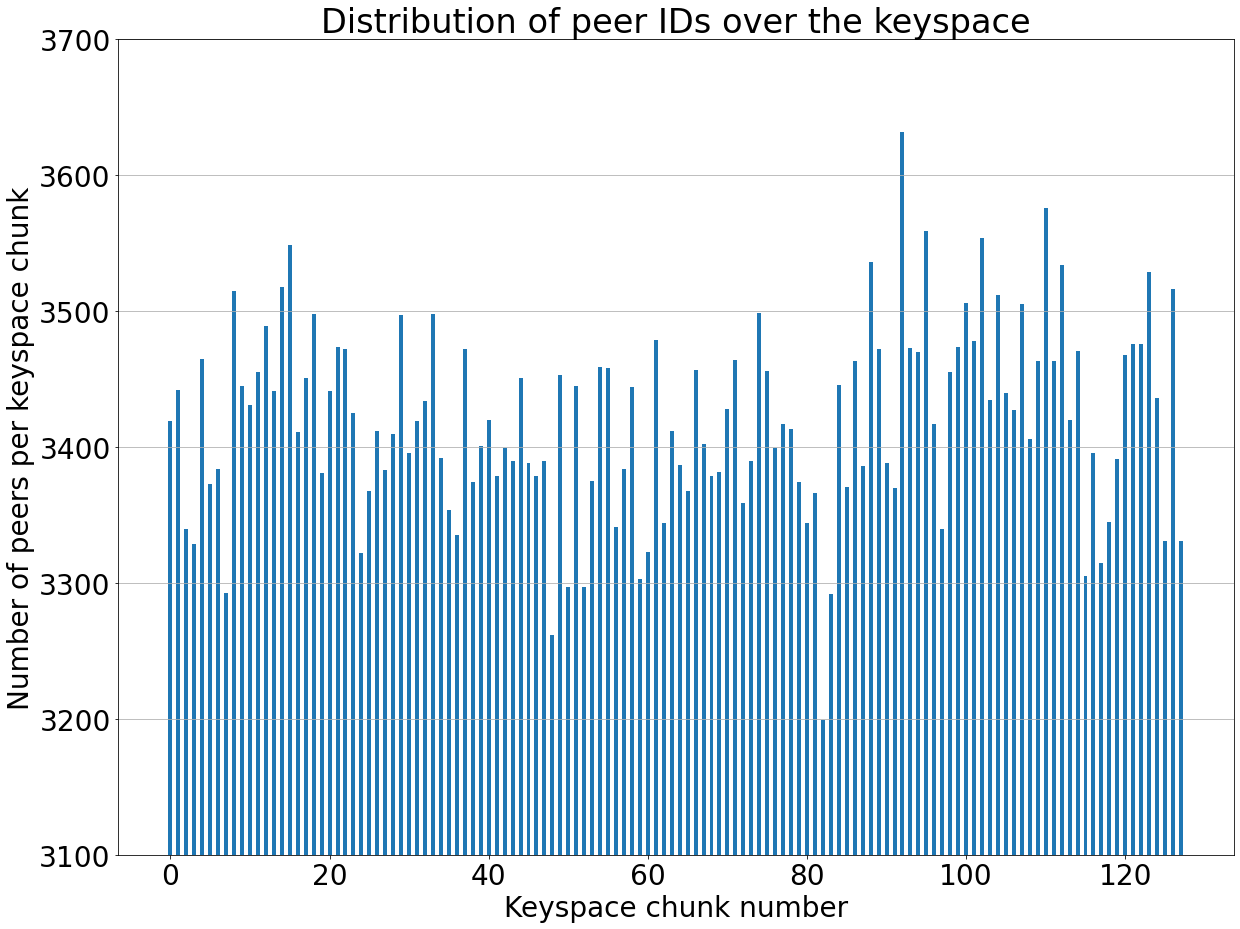

In [139]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.ylim(top=3700, bottom=3100)
plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs over the keyspace")

plt.bar([x for x in range(len(density))], density, width=0.5)

plt.savefig('plots/peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()

In [140]:
levels88_global = 4
density88_global = [0] * 2**levels88_global
for i in range(2**levels88_global):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(levels88_global-len(path))+path # zero padding for constant size bitstring
    path=int_to_bitstring(88,7)+path

    for p in peerids:
        if p[:len(path)] == path:
            density88_global[i]+=1



In [141]:
print("       prefix : occurences\n")
for i in range(len(density88_global)):
    path="{0:b}".format(i)           # getting binary number
    path='0'*(4-len(path))+path
    path=int_to_bitstring(88,7)+path
    
    print(path+":", int(density88_global[i]))

       prefix : occurences

10110000000: 228
10110000001: 207
10110000010: 226
10110000011: 223
10110000100: 226
10110000101: 196
10110000110: 215
10110000111: 212
10110001000: 206
10110001001: 269
10110001010: 241
10110001011: 219
10110001100: 239
10110001101: 191
10110001110: 228
10110001111: 210


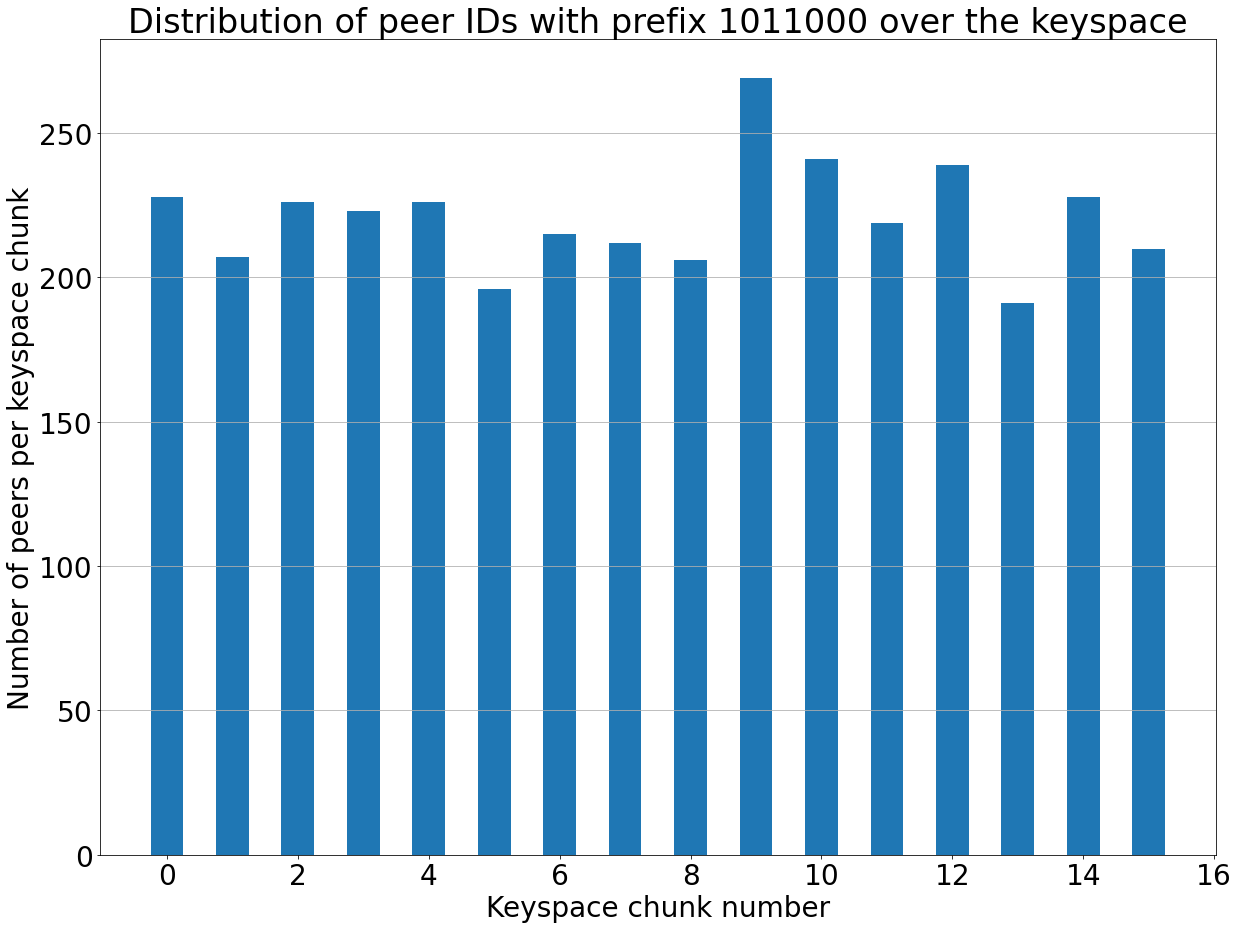

In [142]:
fig = plt.figure(figsize=(20,15), facecolor='white')
plt.grid(axis='y')

plt.xlabel("Keyspace chunk number")
plt.ylabel("Number of peers per keyspace chunk")
plt.title("Distribution of peer IDs with prefix 1011000 over the keyspace")

plt.bar([x for x in range(len(density88_global))], density88_global, width=0.5)

plt.savefig('plots/online-peerid-distribution.png',
            bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w')

plt.show()